In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2


In [2]:
train = pd.read_json('./data/train.json')
test = pd.read_json('./data/test.json')

In [3]:
train.info()
print('-----------------------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8424 entries, 0 to 8423
Data columns (total 4 columns):
band_1       8424 non-null object
band_2       8424 non-null object
id           8424 non-null object
inc_angle    8424 non-null float64
dtypes: float64(1), object(3)
memory usage: 329.1+ KB


In [4]:
train.head(3)

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1


In [5]:
test.head(3)

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433


# First try prediction without angle

## Visualisa some of the images

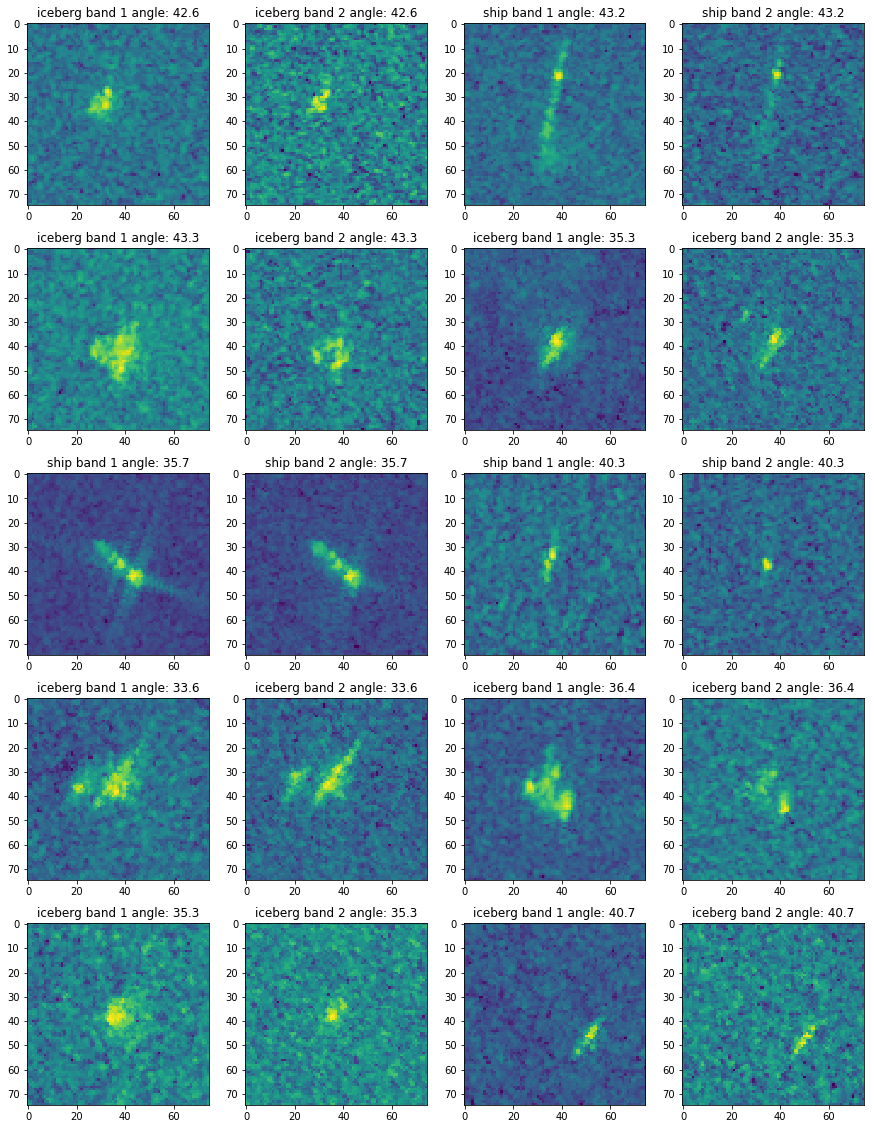

In [6]:
def get_label(label):
    ''' return 'iceberg' if label is 1 '''
    return 'iceberg' if label else 'ship'

f, axes = plt.subplots(5, 4, figsize=(15,20))
for axe in axes:
    i = 0
    for j in range(2):
        index = np.random.randint(len(train))
        img = train.iloc[index]
        band1 = np.resize(np.array(img['band_1']), (75,75))
        band2 = np.resize(np.array(img['band_2']), (75,75))
        axe[i+0].imshow(band1)
        axe[i+0].set_title('{} band 1 angle: {:.3}'.format(get_label(img['is_iceberg']), img['inc_angle']))
        axe[i+1].imshow(band2)
        axe[i+1].set_title('{} band 2 angle: {:.3}'.format(get_label(img['is_iceberg']), img['inc_angle'] ))
        i += 2

Not too sure we can use ConvNet on this task, but... Go Deep Learning!

## Prepare training data

In [12]:
# stack band1 and band2 and average of the two to obtain 'RGB' channel image
def stack_channels(band1_vec, band2_vec, vis=False):
    ''' return stacked three channels image using band1, band2 and average of the two bands
    *paras:
    band1_vec: flattened list of band_1 image data
    band2_vec: flattened list of band_2 image data
    '''
    band1 = np.resize(band1_vec, (75, 75))
    band2 = np.resize(band2_vec, (75, 75))
    band_ave = np.resize((np.array(band1_vec) + np.array(band2_vec))/2, (75, 75))
#     # try stack median
#     band_median = 
    band_rgb = np.zeros((75, 75, 3))
    band_rgb[:,:,0] = band1
    band_rgb[:,:,1] = band2
    band_rgb[:,:,2] = band_ave
    
    if vis == True:
        return band1, band2, band_ave
    else:
        return band_rgb

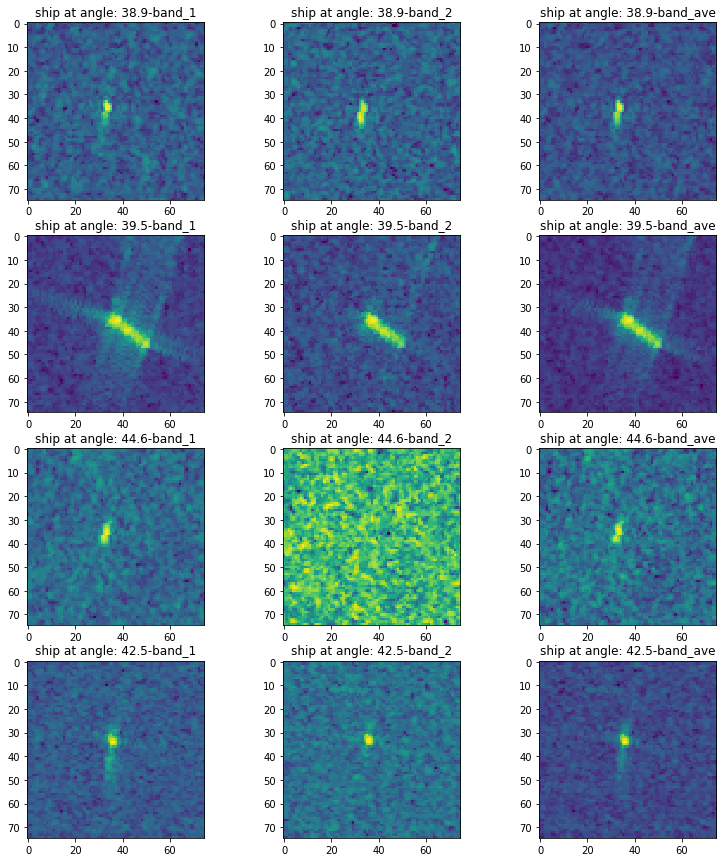

In [13]:
## visualisation of averaged images
f, axes = plt.subplots(4, 3, figsize=(13,15))

for axe in axes:
    i = np.random.randint(len(train))
    img = train.iloc[i]
    band1_vec = img['band_1']
    band2_vec = img['band_2']
    band1, band2, band_ave = stack_channels(band1_vec, band2_vec, True)
    label = get_label(img['is_iceberg'])
    angle = img['inc_angle']
    axe[0].imshow(band1)
    axe[0].set_title('{} at angle: {:.3}-band_1'.format(label, angle))
    axe[1].imshow(band2)
    axe[1].set_title('{} at angle: {:.3}-band_2'.format(label, angle))
    axe[2].imshow(band_ave)
    axe[2].set_title('{} at angle: {:.3}-band_ave'.format(label, angle))    

In [14]:
train.head(1)

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0


In [15]:
images = []
labels = []
for _, row in train.iterrows():
    img = stack_channels(row['band_1'], row['band_2'])
    label = row['is_iceberg']

    # augment the image data
    ## flip left/right
    img_lr = np.fliplr(img)
    ## flip up/down
    img_ud = np.flipud(img)
    ## rotated 90 degree
    img_rot = np.rot90(img)
    
    # add into training set
    images.append(img)
    images.append(img_lr)
    images.append(img_ud)
    images.append(img_rot)
    
    labels.append(label)
    labels.append(label)
    labels.append(label)
    labels.append(label)

assert len(images) == len(labels)
assert len(images) == (4 * len(train))


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dropout, Dense
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [23]:
from keras.optimizers import Adam
from keras import regularizers

In [59]:
X = np.array(images)
y = np.array(labels)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                    random_state=np.random.randint(200), 
                                                    shuffle=True)

In [62]:
model = Sequential()


model.add(Conv2D(12, kernel_size=3, strides=(2,2), input_shape=(75,75,3)))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=3))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(256, kernel_size=2, strides=(1, 1)))
model.add(LeakyReLU())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, kernel_size=2, strides=(1, 1)))
model.add(LeakyReLU())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=2, strides=(1, 1)))
model.add(LeakyReLU())





model.add(Flatten())

model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dropout(0.4))

model.add(Dense(128))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))



In [63]:
opt = Adam(decay=0.1)

In [64]:
model.compile(loss='binary_crossentropy', optimizer=opt)

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 37, 37, 12)        336       
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 37, 37, 12)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 37, 37, 12)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 35, 35, 64)        6976      
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 35, 35, 64)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 256)       65792     
__________

In [ ]:
epochs = 50
batch_size = 64

filepath = 'model-2.h5'
save_best = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
training_log = model.fit(X_train, y_train, 
                         validation_data=(X_val, y_val), shuffle=True, 
                         epochs=epochs, batch_size=batch_size, callbacks=[save_best], verbose=1)

Train on 5132 samples, validate on 1284 samples
Epoch 1/50
5132/5132 [==============================] - 62s - loss: 0.8934 - val_loss: 0.6816
Epoch 2/50
5132/5132 [==============================] - 57s - loss: 0.6886 - val_loss: 0.6679
Epoch 3/50
5132/5132 [==============================] - 56s - loss: 0.6592 - val_loss: 0.6466
Epoch 4/50
5132/5132 [==============================] - 56s - loss: 0.6401 - val_loss: 0.6345
Epoch 5/50
4928/5132 [===========================>..] - ETA: 2s - loss: 0.6240

In [44]:
from keras.models import load_model
model = load_model(filepath)
score = model.evaluate(X_val, y_val, verbose=1)
print('Test loss:', score)


1280/1284 [============================>.] - ETA: 0sTest loss: 0.243206185808


### prediction

In [58]:
test_band_1 = np.array([np.array(band).reshape(75,75) for band in test['band_1']])
test_band_2 = np.array([np.array(band).reshape(75,75) for band in test['band_2']])
X_test = np.zeros((len(test_band_1), 75, 75, 3))
X_test[:,:,:,0] = test_band_1
X_test[:,:,:,1] = test_band_2
X_test[:,:,:,2] = (test_band_1 + test_band_2)/2

In [61]:
pred = model.predict_proba(X_test)

8416/8424 [============================>.] - ETA: 0s

In [67]:
pred

array([[ 0.17008083],
       [ 0.78894281],
       [ 0.75462812],
       ..., 
       [ 0.0019817 ],
       [ 0.99963582],
       [ 0.99955291]], dtype=float32)

## submission

In [73]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['is_iceberg'] = pred

In [74]:
submission.to_csv('./submission_024.csv', index=False)

# Prediction with consideration of inc_angle

In [ ]:
# from collections import Counter
# train_na_count = Counter(train['inc_angle'] == 'na')
# train_na_count

In [ ]:
# # There is no missing angle in test data.
# # although 10% of training data seems a lot... I still decided to remove those entries without inc_angle first
# train = train[~ (train['inc_angle'] == 'na')]